# Test

In [4]:
from astropy.io import fits
import matplotlib.pyplot as plt

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   16 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                 2048                                                  
EXTEND  =                    T                                                  
BZERO   =                32768 / offset data range to that unsigned short       
BSCALE  =                    1                                                  
DATE    = '2023-07-13T11:04:51.62' / file creation date (YYYY-MM-DDThh:mm:ss UT)
FILENAME= 'imoa_06563_l1_20230713_11045162_b1.fts' / Original filename          
DATE_OBS= '2023-07-13T11:04:42.00' / Date start of the observation UT           
EXPTIME =                 0.03 / [s] Exposure time                              
CAMTEM  =                 0.

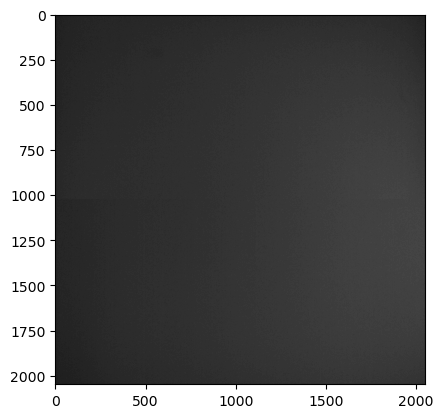

In [10]:
folder = 'Y:/data/CLIMSO/2023/data/2023-07-13/'

with fits.open(folder + 'imoa_06563_l1_20230713_11045162_b1.fts.bz2') as hdul:
    hdu = hdul[0]
    plt.imshow(hdu.data, cmap='gray')
hdu.header